In [1]:
import hashlib
import numpy as np
import math
import collections
from zlib import crc32
import random
import operator
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from sympy import Symbol, solve, log
from scipy.optimize import fsolve
import scipy
import hashlib
import array
import matplotlib.cm as cm
import operator
from collections import defaultdict
import pandas as pd
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__)) 
# use matplotlib: 3.1.0
from spacesaving import SpaceSaving
from githubCountMin import CountMinSketch
from CSSS import CSSS_CountSketch, CSSS_sketch


matplotlib: 3.1.0


In [2]:
    # A simple test
    test = SpaceSaving(2)
    stream = ['a','b','c', 'a', 'a','-a']
    dic = defaultdict(int)
    for item in stream:
        print(item)
        if len(item) == 1:
            test.update(item, 1)
            dic[item]+=1
        else:
            test.update(item[1:], -1)
            dic[item[1:]] -= 1
    test.output()
    print("item, F', F")
    for item in set(stream):
        if len(item) == 1:
            print(item, test.query(item), dic[item])

a
b
c
a
a
-a
weight_heap:  [['c', 2, 0], ['a', 3, 1]]
map:  defaultdict(<class 'int'>, {'c': 0, 'a': 1})
item, F', F
b 0 1
c 2 1
a 2 2


In [3]:
# read CAIDA TCP traces
# the path may need to be updated for others
df = pd.read_csv('./data/tcp/20151217_125911_dirA.csv',sep='\t') 
dip = df[df.columns[3]]

In [6]:
    def frequency_estimation(stream_type, shuffled, arr, skew=1.0, s = 10**5, univ = 2**16):
        ss_avg = {}
        csss_avg = {}
        cm_avg = {}
        cs_avg = {}
        
        total_spaces = {}
    
        Turnstile_model_maker = ['^:','^-.']
        markers = {0.5:['kv-','kv--','kv:']}
        runs = 1
        universe = univ
        size = s
        R = size # assume we can capture R without any error. It is used for the CSSS Sketch
        a = skew
        CAIDASIZE = 2*(10**6)

        epsilons = []
        if stream_type != 'bin':
            epsilons = [2**(-1),2**(-2),2**(-3),2**(-4)]
        else:
            epsilons = [0.8,0.6,0.4,0.2]
        rates = [0.5]
        alphas = [2]
        
        for i in range(len(rates)):
            rate = rates[i]
            alpha = alphas[i]
            ss_avg_errors = []
            csss_avg_errors = []
            cm_avg_errors = []
            cs_avg_errors = []

            total_space = []

            for eps in epsilons:
                sum_ss_avg_error = 0
                sum_csss_avg_error = 0
                sum_cm_avg_error = 0
                sum_cs_avg_error = 0

                first_run = True

                for run in range(runs):

                    CSSS = CSSS_sketch(eps, universe, 1.0/eps, alpha)

                    # CSSS space output the total bits used
                    # SpaceSaving and Linear Sketch use logU bits per counter

                    ss_space = math.ceil( CSSS.space()/math.log2(universe) )
                    SS = SpaceSaving(ss_space)

                    CM = CountMinSketch( math.ceil(1.0*ss_space/math.log2(universe)), math.ceil(math.log2(universe))) #cols, rows
                    CS = CSSS_CountSketch(math.ceil(math.log2(universe)), math.ceil(1.0*ss_space/math.log2(universe)))

                    if first_run:
                        first_run = False
                        total_space.append(CSSS.space())

                    insertions = []
                    deletions = []
                    
                    # makeing sure size = |F| = I-D = insert_size(1-r)
                    insert_size = int(size/(1-rate))

                    if stream_type == 'zipf':
                        range_x = np.arange(1,universe)
                        weights = range_x ** (-a)
                        weights /= weights.sum()
                        bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))

                        insertions = bounded_zipf.rvs(size=insert_size)
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))

                    elif stream_type == 'bin':
                        insertions = list(np.random.binomial(universe, a, insert_size))
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*insert_size))
                        
                    else:
                        assert(len(arr)>0)
                        insertions = arr[run*CAIDASIZE:(run+1)*CAIDASIZE]
                        if shuffled:
                            deletions = random.sample(list(insertions), int(rate*len(insertions)))

                    if not shuffled:
                        dic = collections.Counter(insertions)
                        ordered_dic = collections.OrderedDict(sorted(dic.items(), key=operator.itemgetter(1)))
                        targeted_length = int(rate*len(insertions))
                        for item, val in ordered_dic.items():
                            for i in range(val):
                                if len(deletions)<targeted_length:
                                    deletions.append(item)
                                else:
                                    break
                            if len(deletions)>=targeted_length:
                                break


                    true_result = {}
                    for i in insertions:
                        CSSS.update(str(i), 1)
                        SS.update(str(i), 1)
                        CM.add(str(i), 1)
                        CS.add(str(i), 1)
                        true_result[str(i)] = true_result.get(str(i), 0) + 1

                    for i in deletions:
                        CSSS.update(str(i), -1)
                        SS.update(str(i), -1)
                        CM.add(str(i), -1)
                        CS.add(str(i), -1)
                        true_result[str(i)] -= 1

    
                    csss_avg_error = 0

                    ss_avg_error = 0

                    cm_avg_error = 0
                    cs_avg_error = 0

                    for item in true_result.keys():
                        csss_estimate = CSSS.query(item)
                        csss_error = abs(true_result.get(item,0) - csss_estimate)

                        ss_estimate = SS.query(item)
                        ss_error = abs(true_result.get(item,0) - ss_estimate)

                        cm_estimate = CM.query(item)
                        cm_error = abs(true_result.get(item,0) - cm_estimate)

                        cs_estimate = CS.query(item)
                        cs_error = abs(true_result.get(item,0) - cs_estimate)



                        csss_avg_error += csss_error**2
                        ss_avg_error += ss_error**2
                        cm_avg_error += cm_error**2
                        cs_avg_error += cs_error**2

                    u = len(true_result.keys())
                    csss_avg_error = 1.0*csss_avg_error / u
                    ss_avg_error = 1.0*ss_avg_error / u
                    cm_avg_error = 1.0*cm_avg_error / u
                    cs_avg_error = 1.0*cs_avg_error / u

                    sum_ss_avg_error += ss_avg_error
                    sum_csss_avg_error += csss_avg_error
                    sum_cm_avg_error += cm_avg_error
                    sum_cs_avg_error += cs_avg_error

                ss_avg_errors.append(sum_ss_avg_error/ runs)
                csss_avg_errors.append(sum_csss_avg_error/ runs)
                cm_avg_errors.append(sum_cm_avg_error/ runs)
                cs_avg_errors.append(sum_cs_avg_error/ runs)

            ss_avg[rate] = ss_avg_errors
            csss_avg[rate] = csss_avg_errors
            cm_avg[rate] = cm_avg_errors
            cs_avg[rate] = cs_avg_errors
            total_spaces[rate] = total_space


        plt.figure()
        if stream_type == 'zipf':
            if shuffled:
                plt.title("Zipf("+str(a)+")", fontsize=20) 
            else:
                plt.title("Zipf("+str(a)+"), Delete Least Frequent", fontsize=20) 
            plt.ylim([10**1, 10**9])
        elif stream_type == 'bin':
            if shuffled:
                plt.title("Binomial("+str(a)+")", fontsize=20)
            else:
                plt.title("Binomial("+str(a)+"), Delete Least Frequent", fontsize=20)
            plt.ylim([10**3, 10**9])
        else:
            if shuffled:
                plt.title(str(stream_type)+"", fontsize=20) 
            else:
                plt.title(str(stream_type)+", Delete Least Frequent", fontsize=20) 
            plt.ylim([10**2.5, 10**11])
                
            
        plt.xlabel('Space(bits)', fontsize=19)
        plt.ylabel('MSE', fontsize=19)
        
        plt.rc('xtick',labelsize=15)
        plt.rc('ytick',labelsize=15)
        
        plt.yscale('log', basey=10)
        plt.xscale('log', basex=2)
        for i in range(len(rates)):
            plt.plot(total_spaces[rates[i]], ss_avg[rates[i]], markers[rates[i]][0], label='SpaceSaving\u00B1, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], csss_avg[rates[i]], markers[rates[i]][1],label='CSSS, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], cm_avg[rates[i]], Turnstile_model_maker[0] ,label='Count-Min, '+"D"+str(rates[i]))
            plt.plot(total_spaces[rates[i]], cs_avg[rates[i]], Turnstile_model_maker[1],label='Count Median, '+"D"+str(rates[i]))
        print(total_spaces)
        print(ss_avg)
        print(csss_avg)
        print(cm_avg)
        print(cs_avg)
        plt.legend(prop={'size': 12})
        

{0.5: [1152, 2688, 6144, 13824]}
{0.5: [9448.620742986173, 3337.0882698854844, 1152.747568332923, 374.1129469790382]}
{0.5: [5078810.987286956, 338333.75846487156, 189700.74341295246, 105091.14845869297]}
{0.5: [204209573.02474558, 35358491.55611266, 5956334.395561438, 900880.7705918619]}
{0.5: [1862640.0330894862, 193010.1713865676, 49321.05323504063, 10645.980872379778]}


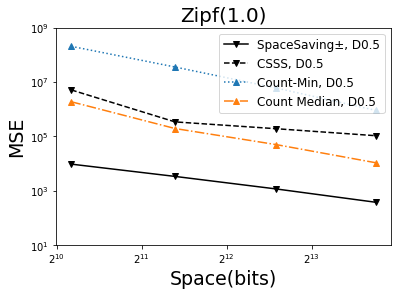

In [7]:
    frequency_estimation('zipf', True, [], 1.0)

{0.5: [1152, 2688, 6144, 13824]}
{0.5: [10260.948446937015, 3488.181894228088, 1138.7643941961123, 366.0668785877415]}
{0.5: [12889464.225009244, 1176950.1901663723, 954879.3685345491, 117292.54675637306]}
{0.5: [74408721.375416, 9096033.669176193, 670995.5161886571, 25132.354237392752]}
{0.5: [3252959.5451513003, 1158590.7546937447, 179611.93112504235, 74041.2307187828]}


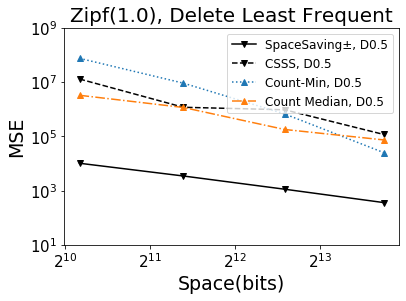

In [8]:
    frequency_estimation('zipf', False, [], 1.0)